In [1]:
import pandas as pd
import numpy as np

In [230]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [9]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score,  recall_score, precision_score
from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)


In [231]:
from my_metr import plot_roc_curve

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
biz_df = pd.read_csv('biz_cluster.csv')

In [3]:
biz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57173 entries, 0 to 57172
Data columns (total 24 columns):
Unnamed: 0                57173 non-null int64
business_id               57173 non-null object
RestaurantsPriceRange2    51111 non-null float64
stars                     57173 non-null float64
review_count              57173 non-null int64
categories                57173 non-null object
cl_0                      25785 non-null float64
cl_1                      37611 non-null float64
cl_2                      6306 non-null float64
cl_3                      327 non-null float64
cl_4                      11547 non-null float64
cl_5                      14129 non-null float64
cl_6                      1 non-null float64
cl_7                      3366 non-null float64
cl_8                      2667 non-null float64
cl_9                      2073 non-null float64
cl_10                     380 non-null float64
cl_11                     2937 non-null float64
cl_12                     47

In [8]:
biz_df.head(3)

,Unnamed: 0,business_id,RestaurantsPriceRange2,stars,review_count,categories,cl_0,cl_1,cl_2,cl_3,...,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17
0,0,--9e1ONYQuAa-CB_Rrw7Tw,4.0,4.0,1546,"Steakhouses, Restaurants, Cajun/Creole",0.0,1.0,2.0,NaN,...,8.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,16.0,17.0
1,1,-VAsjhmAbKF3Pb_-8rh3xg,1.0,2.0,10,"Fast Food, Burgers, Restaurants",NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-cxD1NimFldATDUsN-oa3A,2.0,2.0,23,"Mexican, Restaurants",NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cleaning

In [86]:
biz_cl = biz_df.copy()
for i in range (18):
    col_new = 'cl_t'+str(i)
    col_old = 'cl_'+str(i)
    biz_cl[col_new] = ~pd.isnull(biz_df[col_old])
    biz_cl.drop(col_old, axis =1, inplace= True)


In [87]:
biz_cl.shape

(57173, 24)

In [88]:
biz_cl['how_many_cl'] = 0
for i in range (18):
    col_new = 'cl_t'+str(i)
    biz_cl['how_many_cl'] += biz_cl[col_new]



In [29]:
len(biz_cl[biz_cl['how_many_cl']>4])

5644

In [30]:
len(biz_cl[biz_cl['how_many_cl']>5])

2774

In [33]:
len(biz_cl)

57173

In [111]:
def expand_features(X, col='features', inplace=False, sep=None):
    X = X.copy() if not inplace else X
    if sep==None:
        for i in range(len(X[col].iloc[0])):
             X['feature_' + str(i)] = X[col].apply(lambda x: x[i])
    else:
        lbls = np.unique(sep.join(X[col].unique()).split(sep))
        lbls = np.unique([l.strip() for l in lbls])
        for lbl in lbls:
            X[lbl] = X[col].apply(lambda x: lbl in x)
        X.drop(col, axis=1, inplace=True)
    return X

In [113]:
biz_cl1 = expand_features(biz_cl, col='categories', sep =',')

In [123]:
biz_cl1['num_of_categ'] = biz_df.categories.map(lambda x: len(x.split(',')))

In [133]:
biz_cl1.shape, biz_cl1.columns[:27]

((57173, 732),
 Index(['Unnamed: 0', 'business_id', 'RestaurantsPriceRange2', 'stars',
        'review_count', 'cl_t0', 'cl_t1', 'cl_t2', 'cl_t3', 'cl_t4', 'cl_t5',
        'cl_t6', 'cl_t7', 'cl_t8', 'cl_t9', 'cl_t10', 'cl_t11', 'cl_t12',
        'cl_t13', 'cl_t14', 'cl_t15', 'cl_t16', 'cl_t17', 'how_many_cl',
        'num_of_categ', '& Probates', 'Acai Bowls'],
       dtype='object'))

In [131]:
colClust =['cl_t0', 'cl_t1', 'cl_t2', 'cl_t3', 'cl_t4', 'cl_t5',
        'cl_t6', 'cl_t7', 'cl_t8', 'cl_t9', 'cl_t10', 'cl_t11', 'cl_t12',
        'cl_t13', 'cl_t14', 'cl_t15', 'cl_t16', 'cl_t17']

In [132]:
biz_cl1[colClust].corr()

,cl_t0,cl_t1,cl_t2,cl_t3,cl_t4,cl_t5,cl_t6,cl_t7,cl_t8,cl_t9,cl_t10,cl_t11,cl_t12,cl_t13,cl_t14,cl_t15,cl_t16,cl_t17
cl_t0,1.000000,0.385155,0.286471,-0.011409,0.359006,0.303135,0.004614,0.064800,0.135711,0.097607,0.030550,0.142260,0.020644,0.139987,-0.013389,NaN,0.182701,0.122248
cl_t1,0.385155,1.000000,0.207322,0.002877,0.283651,0.271736,0.003016,0.075600,0.117397,0.080720,0.040843,0.120563,0.031362,0.104162,0.005305,NaN,0.132429,0.083333
cl_t2,0.286471,0.207322,1.000000,-0.005973,0.375981,0.256510,0.011878,0.036705,0.146902,0.101063,0.030295,0.150761,0.006901,0.182404,0.002018,NaN,0.237500,0.172109
cl_t3,-0.011409,0.002877,-0.005973,1.000000,-0.001758,0.000640,-0.000317,-0.010102,-0.000279,0.000178,-0.000495,-0.001889,-0.006905,0.001694,0.007190,NaN,0.000418,0.010531
cl_t4,0.359006,0.283651,0.375981,-0.001758,1.000000,0.324164,-0.002104,0.025576,0.162456,0.102158,0.051609,0.187061,0.024644,0.209060,-0.004236,NaN,0.266616,0.198332
cl_t5,0.303135,0.271736,0.256510,0.000640,0.324164,1.000000,-0.002396,-0.042693,0.066129,0.032474,0.066918,0.085634,0.044841,0.147620,-0.009796,NaN,0.252479,0.143075
cl_t6,0.004614,0.003016,0.011878,-0.000317,-0.002104,-0.002396,1.000000,-0.001046,-0.000925,-0.000811,-0.000342,-0.000973,-0.000381,-0.000733,-0.000106,NaN,-0.000997,-0.000662
cl_t7,0.064800,0.075600,0.036705,-0.010102,0.025576,-0.042693,-0.001046,1.000000,-0.013043,-0.023073,-0.016801,-0.021513,-0.021948,-0.005869,-0.000521,NaN,0.007214,0.035977
cl_t8,0.135711,0.117397,0.146902,-0.000279,0.162456,0.066129,-0.000925,-0.013043,1.000000,0.043614,-0.008907,0.098812,-0.018302,0.096724,0.000894,NaN,0.081060,0.054167
cl_t9,0.097607,0.080720,0.101063,0.000178,0.102158,0.032474,-0.000811,-0.023073,0.043614,1.000000,-0.004351,0.243086,0.011356,0.052872,-0.001257,NaN,0.052032,0.042026


In [135]:
mmm = biz_cl1[biz_cl1.columns[25:]].mean(axis = 0)

In [136]:
mmm.describe()

count    707.000000
mean       0.005864
std        0.042220
min        0.000017
25%        0.000017
50%        0.000087
75%        0.000883
max        1.000000
dtype: float64

In [151]:
ll = mmm[mmm<0.0005]

In [152]:
ll.to_csv('d.txt')

In [153]:
len(ll)

499

In [158]:
biz_cl2 = biz_cl1.drop(ll.index, axis = 1)

In [160]:
biz_cl2.shape

(57173, 233)

In [297]:
biz_cl2.review_count.describe()

count    57173.000000
mean        63.924108
std        162.644692
min          3.000000
25%          7.000000
50%         19.000000
75%         59.000000
max       7968.000000
Name: review_count, dtype: float64

In [161]:
biz_cl2['rest_isna'] = pd.isnull(biz_cl2['RestaurantsPriceRange2'])
biz_cl2['RestaurantsPriceRange2'][pd.isnull(biz_cl2['RestaurantsPriceRange2'])] =2

mmmm = biz_cl2[biz_cl2.columns[21:] ].mean(axis = 0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [300]:
rev_norm = biz_cl2['review_count'].map(lambda x: x if x < 250 else 250)
biz_cl2['st_over_am'] = biz_cl2['stars']/rev_norm

In [281]:
biz_cl2.columns

Index(['Unnamed: 0', 'business_id', 'RestaurantsPriceRange2', 'stars',
       'review_count', 'cl_t0', 'cl_t1', 'cl_t2', 'cl_t3', 'cl_t4',
       ...
       'Venues & Event Spaces', 'Vietnamese', 'Waffles', 'Whiskey Bars',
       'Wine & Spirits', 'Wine Bars', 'Wineries', 'Wraps', 'rest_isna',
       'st_over_am'],
      dtype='object', length=235)

In [302]:
colPred = biz_cl2.columns[2:4].union( biz_cl2.columns[24:])
colPred

Index(['Acai Bowls', 'Active Life', 'Afghan', 'African', 'American (New)',
       'American (Traditional)', 'Arabian', 'Arcades', 'Argentine',
       'Art Galleries',
       ...
       'Waffles', 'Whiskey Bars', 'Wine & Spirits', 'Wine Bars', 'Wineries',
       'Wraps', 'num_of_categ', 'rest_isna', 'st_over_am', 'stars'],
      dtype='object', length=213)

In [283]:
colClust_n

['cl_t0',
 'cl_t1',
 'cl_t2',
 'cl_t3',
 'cl_t4',
 'cl_t5',
 'cl_t7',
 'cl_t8',
 'cl_t9',
 'cl_t10',
 'cl_t11',
 'cl_t12',
 'cl_t13',
 'cl_t14',
 'cl_t16',
 'cl_t17']

In [303]:
X = biz_cl2[colPred]
####
Y = biz_cl2[colClust_n] 

In [304]:
X_train, X_test, Y_train, Y_test = train_test_split(  X, Y, test_size=0.33, random_state=91)

In [286]:
Y_train.head(3)

,cl_t0,cl_t1,cl_t2,cl_t3,cl_t4,cl_t5,cl_t7,cl_t8,cl_t9,cl_t10,cl_t11,cl_t12,cl_t13,cl_t14,cl_t16,cl_t17
4921,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
34910,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
17982,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [257]:
cw = Y_train.mean(axis =0)

In [277]:
cw.index

Index(['cl_t0', 'cl_t1', 'cl_t2', 'cl_t3', 'cl_t4', 'cl_t5', 'cl_t6', 'cl_t7',
       'cl_t8', 'cl_t9', 'cl_t10', 'cl_t11', 'cl_t12', 'cl_t13', 'cl_t14',
       'cl_t15', 'cl_t16', 'cl_t17'],
      dtype='object')

In [264]:
weights = {}
for cl in cw.index:
    weights[cl] = {}
    weights[cl][1] = max(round(cw[cl],2),0.1)
    weights[cl][0] = 1 - weights[cl][1]
weights









{'cl_t0': {1: 0.45, 0: 0.55},
 'cl_t1': {1: 0.66, 0: 0.33999999999999997},
 'cl_t2': {1: 0.11, 0: 0.89},
 'cl_t3': {1: 0.1, 0: 0.9},
 'cl_t4': {1: 0.2, 0: 0.8},
 'cl_t5': {1: 0.25, 0: 0.75},
 'cl_t6': {1: 0.1, 0: 0.9},
 'cl_t7': {1: 0.1, 0: 0.9},
 'cl_t8': {1: 0.1, 0: 0.9},
 'cl_t9': {1: 0.1, 0: 0.9},
 'cl_t10': {1: 0.1, 0: 0.9},
 'cl_t11': {1: 0.1, 0: 0.9},
 'cl_t12': {1: 0.1, 0: 0.9},
 'cl_t13': {1: 0.1, 0: 0.9},
 'cl_t14': {1: 0.1, 0: 0.9},
 'cl_t15': {1: 0.1, 0: 0.9},
 'cl_t16': {1: 0.1, 0: 0.9},
 'cl_t17': {1: 0.1, 0: 0.9}}

In [278]:
colClust_n = ['cl_t0', 'cl_t1', 'cl_t2', 'cl_t3', 'cl_t4', 'cl_t5',  'cl_t7',
       'cl_t8', 'cl_t9', 'cl_t10', 'cl_t11', 'cl_t12', 'cl_t13', 'cl_t14',
        'cl_t16', 'cl_t17']

In [305]:
rf0 = RandomForestClassifier(n_estimators=400,  max_depth=6, 
                             min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=17, 
                             max_leaf_nodes=None, bootstrap=True, n_jobs=-1, 
                             random_state=179,   class_weight={0:1, 1:0.9})

In [306]:
rf0.fit(X_train, Y_train['cl_t0'])

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 0.9},
            criterion='gini', max_depth=6, max_features=17,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=False, random_state=179,
            verbose=0, warm_start=False)

In [307]:
probs = rf0.predict_proba(X_train)

In [214]:
%%time
cross_val_score(rf0,X_train,Y_train['cl_t0'],scoring= 'neg_log_loss')

CPU times: user 27.3 s, sys: 1.29 s, total: 28.6 s
Wall time: 7.91 s


array([-0.64195637, -0.64302025, -0.64143821])

In [215]:
%%time
cross_val_score(rf0,X_test,Y_test['cl_t0'],scoring= 'neg_log_loss')

CPU times: user 13.3 s, sys: 1.43 s, total: 14.7 s
Wall time: 5.15 s


array([-0.64231128, -0.64421853, -0.64476238])

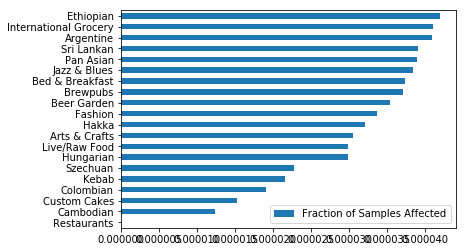

In [195]:
#feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf0.feature_importances_},
                           index=X.columns)
#feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')[:20]
#feat_scores.plot(kind='barh')

In [308]:
roc_auc_score(Y_train['cl_t0'], probs[:,1])

0.8526941057534566

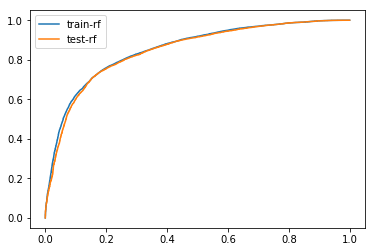

In [309]:
fig, ax = plt.subplots()
plot_roc_curve(Y_train['cl_t0'], X_train, rf0, ax,  'train-rf')
plot_roc_curve(Y_test['cl_t0'], X_test, rf0, ax,  'test-rf')
ax.legend()

In [310]:
gr0 = GradientBoostingClassifier( learning_rate=0.1, n_estimators=300,
                                  subsample=0.8,  
                                   max_depth=7,  random_state=179, max_features='sqrt')

In [311]:
%%time
gr0.fit(X_train, Y_train['cl_t0'])

CPU times: user 22.7 s, sys: 139 ms, total: 22.9 s
Wall time: 22.9 s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=179, subsample=0.8, verbose=0,
              warm_start=False)

In [227]:
%%time
cross_val_score(gr0,X_test,Y_test['cl_t0'],scoring= 'neg_log_loss')

CPU times: user 22.9 s, sys: 113 ms, total: 23 s
Wall time: 23 s


array([-0.60153555, -0.60666749, -0.61542372])

In [312]:
roc_auc_score(Y_train['cl_t0'], gr0.predict_proba(X_train)[:,1]), roc_auc_score(Y_test['cl_t0'], gr0.predict_proba(X_test)[:,1])

(0.9096924382208591, 0.8773976794606934)

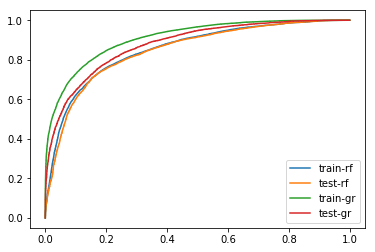

In [313]:
fig, ax = plt.subplots()
plot_roc_curve(Y_train['cl_t0'], X_train, rf0, ax,  'train-rf')
plot_roc_curve(Y_test['cl_t0'], X_test, rf0, ax,  'test-rf')
plot_roc_curve(Y_train['cl_t0'], X_train, gr0, ax,  'train-gr')
plot_roc_curve(Y_test['cl_t0'], X_test, gr0, ax,  'test-gr')

ax.legend()

In [ ]:
%%time
param_grid = {'max_depth' : [5,8, 12 ], 'max_features':[5,10,20,25] }
clust_model_rf ={}
for col in colClust_n:
    rf_c_grid =  GridSearchCV(RandomForestClassifier(n_estimators=400,  
                             min_samples_split=2, min_samples_leaf=1,   
                             max_leaf_nodes=None, bootstrap=True, n_jobs=-1, 
                             random_state=179,   class_weight=weights[col]),
                             param_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_log_loss')
    rf_c_grid.fit(X_train, Y_train[col])
    clust_model_rf[col] = rf_c_grid.best_estimator_
    #params = 
   # print("fot cluster ",col, " best parameters:", clust_model_rf[col].)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.5min finished


In [268]:
%%time
#colClust
param_grid = {'max_depth' : [3,6,8 ], 'learning_rate':[0.05, 0.1] }
clust_model_gr ={}
for col in colClust:
    gr_c_grid = GridSearchCV(GradientBoostingClassifier( n_estimators=300,
                                  subsample=0.8,  
                                     random_state=179, max_features='sqrt'),
                             param_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_log_loss')
    gr_c_grid.fit(X_train, Y_train[col])
    clust_model_gr[col] = gr_c_grid.best_estimator_
    #print("fot cluster ",col, " best parameters:", gr_c_grid.best_params_)
    

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.9min finished


AttributeError: 'GradientBoostingClassifier' object has no attribute 'copy'

dict_keys(['cl_t0'])

In [ ]:
fig, axs = plt.subplots(6,3, figsize = (20,10))
for col, ax in zip(colClust, axs.flatten())
    plot_roc_curve(Y_test[col], X_test, clust_model_rf[col], ax,  'test-rf')
    plot_roc_curve(Y_test[col], X_test, clust_model_gr[col], ax,  'test-gr')
    
    ax.legend()